In [1]:
#First tradingEnv class
#todo add transaction cost
# add MACD indicator
# add RSI indicator
# add SMA indicator
# add EMA indicator
# meerdere crypto's toevoegen ( momenteel alleen BTC)
import numpy as np
import pandas as pd
class TradingEnv():
    def __init__(self, initial_investment=20000, Terminal_state= 2000):
        #investment
        self.initial_investment = initial_investment #initial investment 
        self.Terminal_state = Terminal_state  #terminal state, when the agent reach this state or below, the episode is over
        self.current_investment = initial_investment #current investment in a certain state
        self.non_invested = initial_investment #non invested money in a certain state
        self.invested = 0
        self.worth_history = [] #worth history in a certain episode
        # self.invested = [{'amount': 0, 'price_investment': 0, 'timestamp' : UNIX timestamp of investment}] #invested money 
        self.invested_amount = 0
        
        #rewards
        self.current_reward = 0 #current reward in a certain state
        self.total_reward = 0   #total reward in a certain episode
        self.reward_history = [] #reward history in a certain episode
        self.iterations = 0

        #states
        self.current_price = [0,0,0,0] #current price in a certain state [open,high,low,close]
        self.prev_price = np.zeros(20) #previous 20 prices to keep in memory to the state values
        self.done = False #if the episode is over
        self.current_unix_time = 0 #current unix time in a certain state
        self.macd = 0 #macd indicator
        
        
        #actions
        self.action = 0 #chosen action in a certain state
        self.action_history = [] #action history in a certain episode
        self.action_space = np.array([0,1,2]) #action space, 0 = hold, 1 = buy, 2 = sell first in the array 

        #Current state
        # self.current_state = self.get_current_state() #current state
        self.csv_to_dataframe() #convert csv's to one dataframe
        self.csv_index = 0 #index of the csv dataframe


    def get_current_state(self):
        #return current state price, and invested/non invested values as state
        return [self.current_price[0],self.current_price[1],self.current_price[2],self.current_price[3], self.invested, self.non_invested, self.invested_amount, self.current_unix_time, self.macd,self.sma10,self.sma20]
    # def calculate_macd(self):
    #     #calculate macd indicator
    #     print("macd")
    #     # print(self.df.iloc[self.csv_index - 12 : self.csv_index, 3])
    #     # print(self.df.iloc[self.csv_index - 12 : self.csv_index, 3].ewm(span=12, adjust=False).mean())
    #     macd = self.df.iloc[self.csv_index - 500 : self.csv_index, 3].ewm(span=500, adjust=False).mean()
    #     macd = macd.tolist()
    #     print('res',macd)
    #     # print('res',type(macd.tolist()))
    #     print("average macd", sum(macd) / len(macd))

        return macd
    def reset(self, demo=False):
        #reset the environment
        self.worth_history = []
        self.current_investment = self.initial_investment
        self.current_reward = 0
        self.total_reward = 0
        self.reward_history = []
        self.current_price = [0,0,0,0] #current price in a certain state [open,high,low,close]
        self.invested_amount = 0
        self.non_invested = self.initial_investment #non invested money in a certain state
        self.invested = 0
        self.worth_history = [] #worth history in a certain episode

        self.prev_price = np.zeros(20)
        self.action = 0
        self.action_history = []
        self.done = False
        self.current_unix_time = 0 #current unix time in a certain state
        self.csv_index = 0 #index of the csv dataframe


        #begin somewhere random in csv data 
        if demo == False:
            #last 6months as test set
            self.csv_index = np.random.randint(0, (len(self.df)/2) + 20000)
        else:
            self.csv_index = len(self.df) - 262975
        #get row csv_index from self.df
        self.current_price = self.df.iloc[self.csv_index, 3:7].values
        self.current_unix_time = self.df.iloc[self.csv_index, 0]
        
        self.macd =  self.df.iloc[self.csv_index, 10]
        self.sma20 =  self.df.iloc[self.csv_index, 9]
        self.sma10 =  self.df.iloc[self.csv_index, 11]






        return self.get_current_state(), self.done

    def step(self, action, interval = 1):
        self.iterations += 1
        self.action = action
        self.action_history.append(self.action)
        
        #calculate current reward
        self.current_reward = self.get_reward()
        self.done = self.is_done()
        #if the episode is over, give a big negative reward
        if self.done == True:
            self.current.reward - 1000000

        self.total_reward += self.current_reward
        self.reward_history.append(self.current_reward)

        #get next line of data in csv
        if self.csv_index < len(self.df) - 1:
            try:
                self.csv_index += interval
                self.current_price = self.df.iloc[self.csv_index, 3:7].values
                self.current_unix_time = self.df.iloc[self.csv_index, 0]
                self.macd =  self.df.iloc[self.csv_index, 10]
                self.sma20 =  self.df.iloc[self.csv_index, 9]
                self.sma10 =  self.df.iloc[self.csv_index, 11]
            except Exception as ex:
                print("ex: ", ex)
                print("csv_index: ", self.csv_index)
                self.done = True
                

        else:
            self.done = True
        return self.get_current_state(), self.current_reward, self.done
        
    
    def get_reward(self):
        #reward function
        if self.action == 0:
            #hold do nothing
            reward = 1
        elif self.action == 1:
            #buy = invest 1/10 of non_invested money
            to_invest = self.non_invested / 10
            self.non_invested -= to_invest
            amount = to_invest / self.current_price[0]
            self.invested += to_invest
            self.invested_amount += amount
            reward = 1
        elif self.action == 2:
            #sell first bought in array of invested
            if self.invested > 0:
                amount = self.invested_amount
                price_investment = self.invested
                self.non_invested += amount * self.current_price[0]
                self.invested_amount = 0
                self.invested = 0

                reward = (amount * self.current_price[0]) - price_investment
            else:
                #hold, do nothing, nothing to sell
                reward = 1
        
        self.worth_history.append(self.calc_current_worth())
        return reward * ((self.calc_current_worth()/self.initial_investment)**2)


    def is_done(self):
        #terminal state
        if self.calc_current_worth() <= self.Terminal_state:
            return True
        else:
            return False

    def calc_current_worth(self):
        #calculate current worth
        return self.invested_amount * self.current_price[0] + self.non_invested

        
    def csv_to_dataframe(self):
        #convert csv's to one dataframe
        df2017 = pd.read_csv('./data/BTC-2017min.csv')
        df2018 = pd.read_csv('./data/BTC-2018min.csv')
        df2019 = pd.read_csv('./data/BTC-2019min.csv')
        df2020 = pd.read_csv('./data/BTC-2020min.csv')
        df2021 = pd.read_csv('./data/BTC-2021min.csv')

        #concat all dataframes
        df = pd.concat([df2017, df2018, df2019, df2020, df2021], ignore_index=True)
        #add new column named macd, that is the mean of the last 12 open values
        df['sma20000'] = df['open'].rolling(window=20000).mean()
        self.df = df
        df['macd20000'] = df['open'].rolling(window=20000).mean()**2
        self.df = df
        df['sma10000'] = df['open'].rolling(window=20000).mean()
        self.df = df
        #len = 2675301

In [2]:
#DQN 
import gym
import random
import numpy as np
import matplotlib.pyplot as plt
import collections

# Import Tensorflow libraries

import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow import keras


###### Tensorflow-GPU ########

physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)


c:\Users\cedri\anaconda3\envs\ResearchProj\lib\site-packages\scipy\__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.3)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "


In [5]:
#DQN 
import gym
import random
import numpy as np
import matplotlib.pyplot as plt
import collections

# Import Tensorflow libraries

import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow import keras


###### Tensorflow-GPU ########

physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)


c:\Users\cedri\anaconda3\envs\ResearchProj\lib\site-packages\scipy\__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.3)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "


c:\Users\cedri\anaconda3\envs\ResearchProj\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


shape
(11,)
ep  0  worth  19994.45383633875 episodeReward for episode  0 =  4991.684390375602 with epsilon =  0.01
shape
(11,)
ep  1  worth  20034.681129571938 episodeReward for episode  1 =  5052.074008062681 with epsilon =  0.01


c:\Users\cedri\anaconda3\envs\ResearchProj\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\cedri\AppData\Local\Temp\ipykernel_10580\1045827473.py:287: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


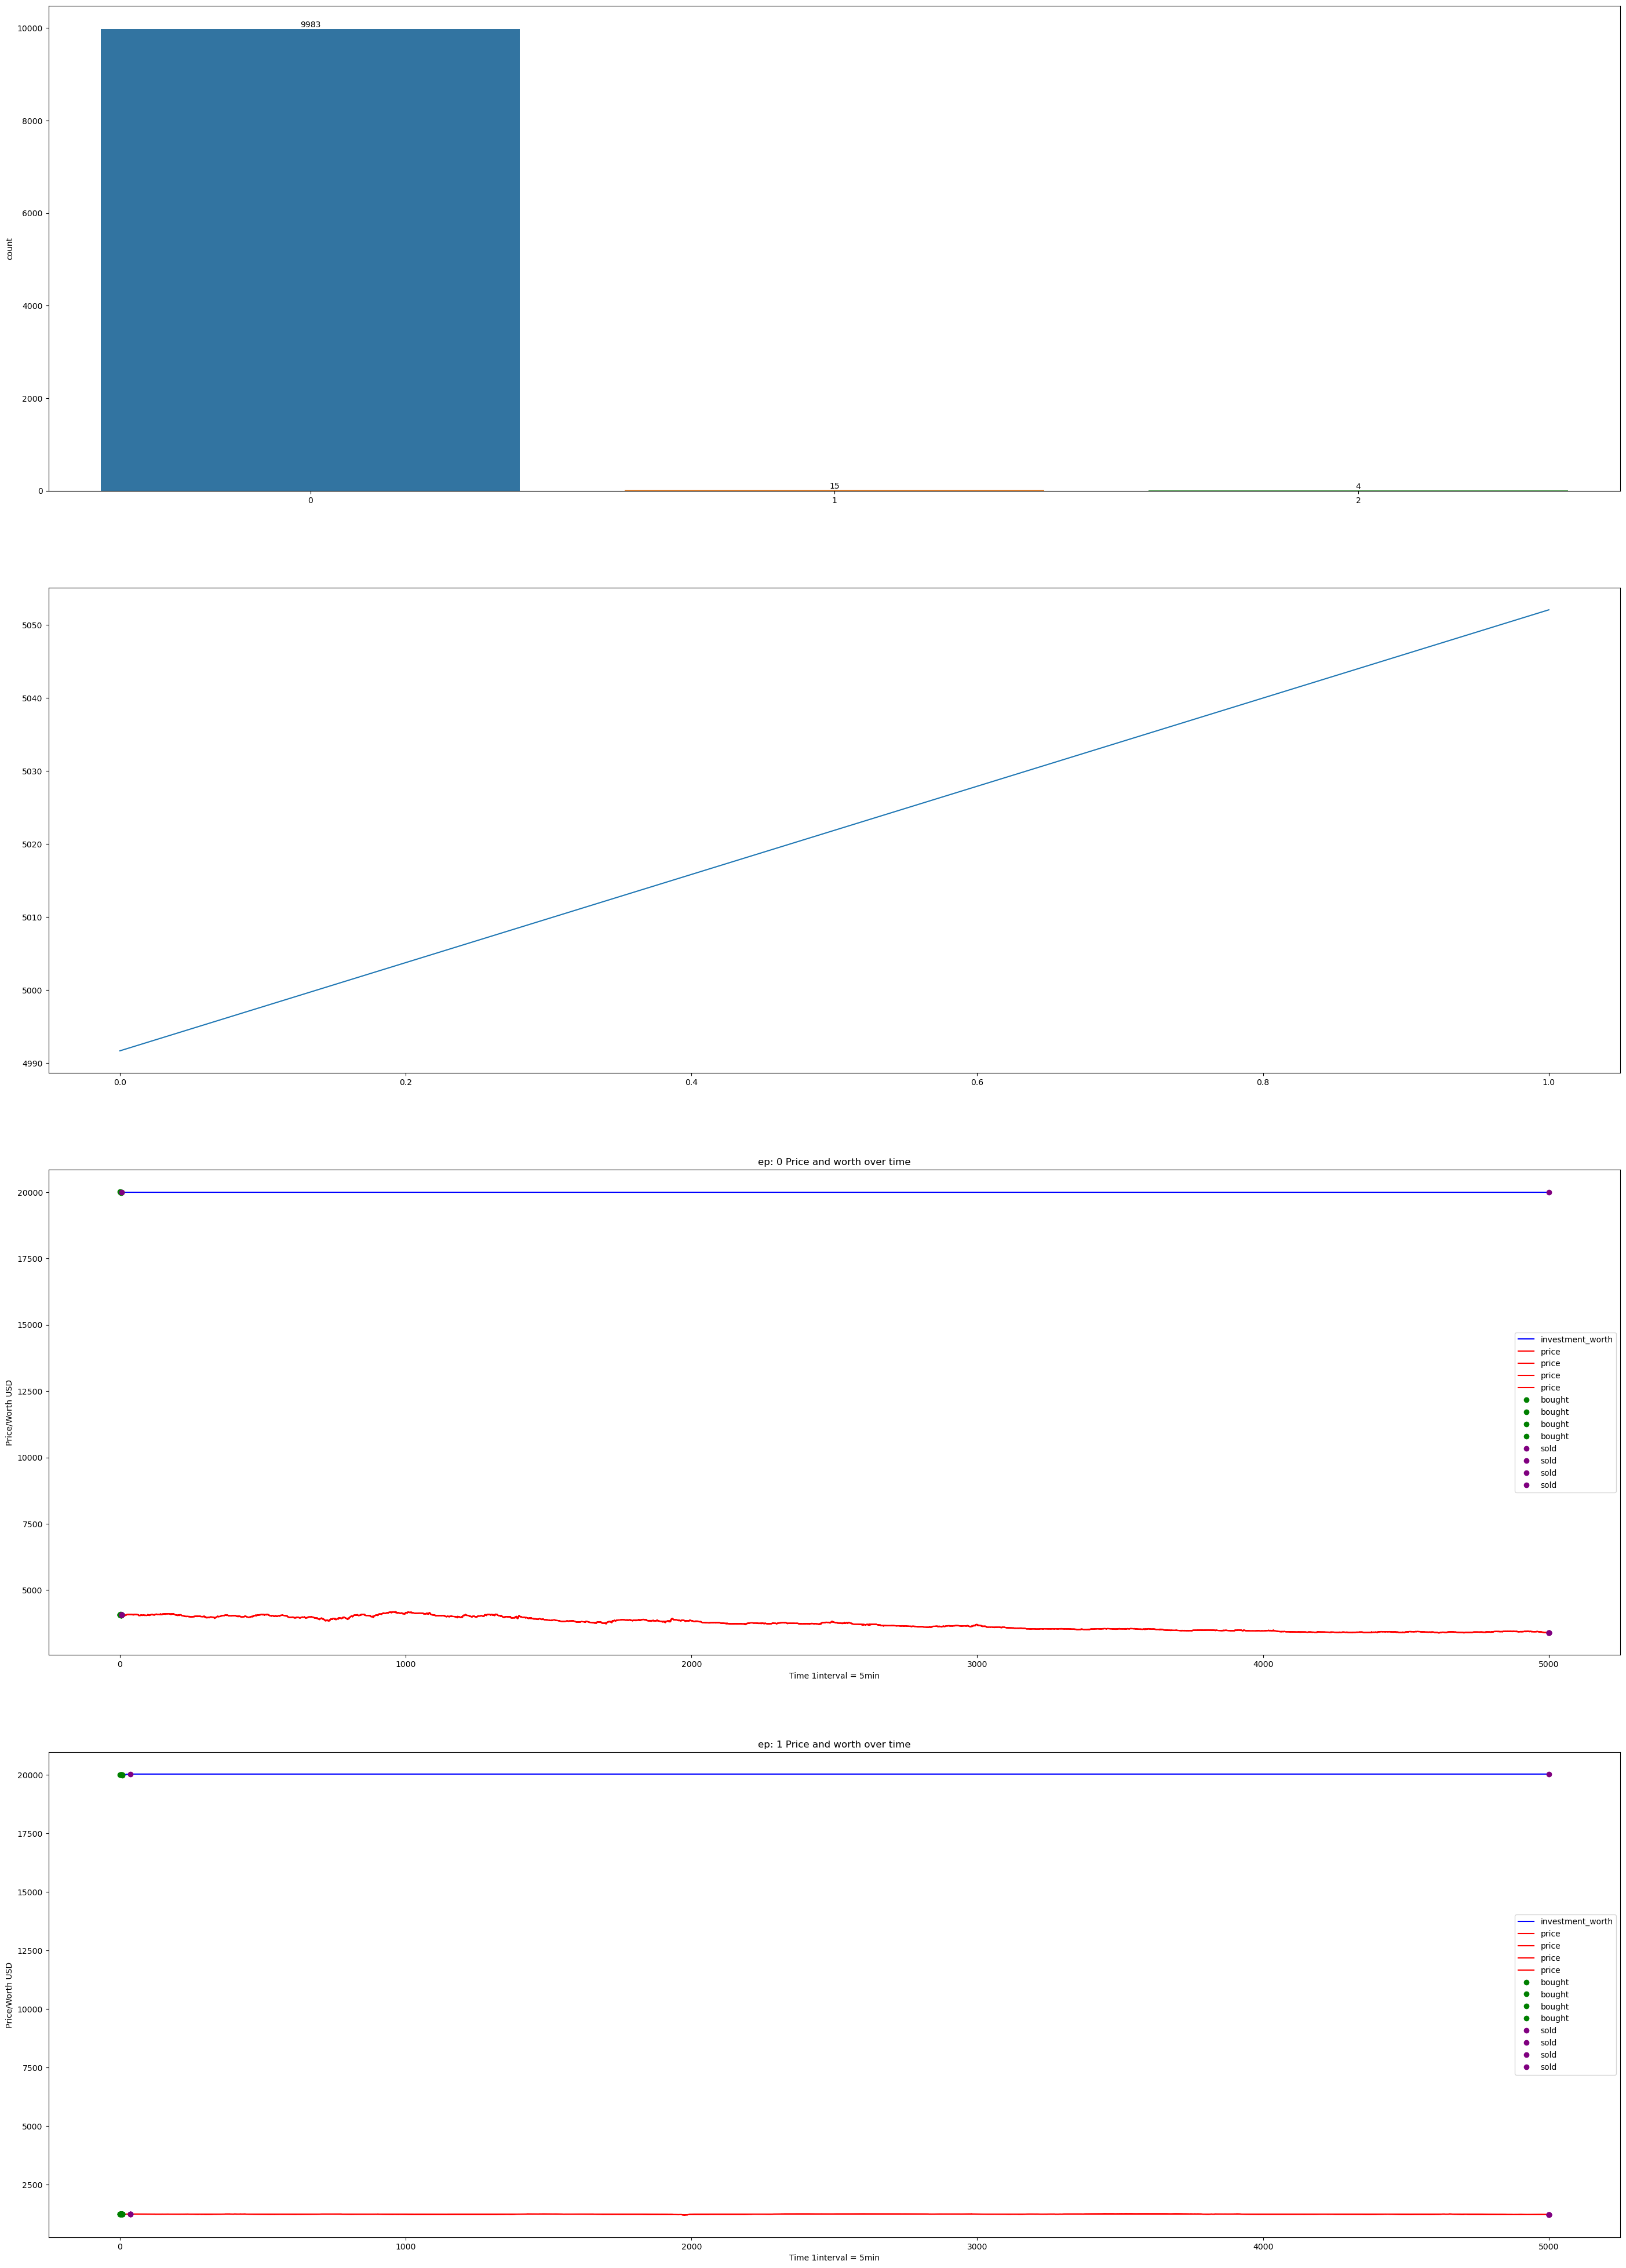

In [12]:
import seaborn as sns


class DQAgent:

    def __init__(self, replayCapacity, inputShape):
        ## Initialize replay memory
        self.capacity = replayCapacity
        self.memory = collections.deque(maxlen=self.capacity)
        self.populated = False
        ## q network
        self.inputShape = inputShape
        self.q_model = self.buildNetwork()

        ## Target network
        self.target_model = self.buildNetwork()
        self.target_model.set_weights(self.q_model.get_weights())

    def addToReplayMemory(self, step):
        self.step = step
        self.memory.append(self.step)

    def sampleFromReplayMemory(self, batchSize):
        self.batchSize = batchSize
        if self.batchSize > len(self.memory):
            self.populated = False
            return self.populated
        else:
            return random.sample(self.memory, self.batchSize)


    def buildNetwork(self):
        model = Sequential()
        model.add(Dense(24, input_shape=self.inputShape, activation='relu'))
        #model.add(BatchNormalization())
        model.add(Dense(24, activation='relu'))
        #model.add(BatchNormalization())
        model.add(Dense(3, activation='linear'))
        model.compile(loss='mse', optimizer=Adam(lr = 0.001), metrics=['MeanSquaredError'])
        return model

    def q_network_fit(self,batch, batchSize):
        self.batchSize = batchSize
        self.batch = batch


    def q_network_predict(self, state):
        self.state = state
        self.qPolicy = self.q_model.predict(self.state, verbose = 0)
        return self.qPolicy

    def target_network_predict(self, state):
        self.state = state
        self.qTarget = self.target_model.predict(self.state, verbose = 0)
        return self.qTarget

    def update_target_network(self):
        self.target_model.set_weights(self.q_model.get_weights())



# Model parameters

DISCOUNT = 0.90
REPLAY_MEMORY_CAPACITY = 5000
#MIN_REPLAY_MEMORY_SIZE = 1_000  # Minimum number of steps in a memory to start training
BATCH_SIZE = 64  # How many steps (samples) to use for training
UPDATE_TARGET_INTERVAL = 1000
EPSILON = 0.5 # Exploration percentage
MIN_EPSILON = 0.05
POSSIBLE_ACTIONS = [0,1,2]
DECAY = 0.999



# Create Cartpole environment
env = TradingEnv()
state, done = env.reset()

#state = env.reset()

# create DQN agent

agent = DQAgent(replayCapacity= REPLAY_MEMORY_CAPACITY, inputShape= (11,))
# agent.q_model = keras.models.load_model('mountaincar')
# agent.update_target_network()

# Fill the replay memory with the first batch of samples

updateCounter = 0
rewardHistory = []


score_history = []
    
steps = []

num_episodes = 2
fullcounter = 0
maxIterations = 5000
allEpisodesWorth = []
allEpisodesPrice = []
AllEpisodesSold = []
AllEpisodesBought = []


for episode in range(num_episodes):
    episodeReward = 0
    stepCounter = 0  # count the number of successful steps within the episode

    #print('\n', episode)
    state, done = env.reset()
    #state = np.expand_dims(state, axis=0)
    worth_history = []
    price_history = []
    bought = []
    sold = []
    done = False
    score = 0
    state = np.asarray(state)
    print("shape")
    print(state.shape)
    counter = 0
    lastBuy = -9999
    lastSold = -9999
    stop = False
    startprice = state[0]

    while stop == False and done == False:
        counter+=1
        fullcounter += 1

        # if counter%10== 0:
            # env.render()

        r = random.random()

        if r <= EPSILON:
            action = random.sample(POSSIBLE_ACTIONS, 1)[0]
            #print('exploration')
        else:
            #print('exploitation')
            qValues = agent.q_network_predict(state.reshape(1,-1))
            action = np.argmax(qValues[0] )
            #print('action =', action)
            #print(qValues)
        if env.invested < 10:
            action = 0
        if action == 1:
            if counter - lastBuy > 200 and counter - lastSold > 100:

                action = 1
                lastBuy = counter
            else:
                action = 0
        if counter - lastBuy > 10000:
                action = 1
        if action == 2 and counter - lastSold < 100:
            if counter - lastBuy > 200:
                action = 2
            else:
                action = 0
        if env.invested > 15000 and action == 1: 
                action = 0
        if counter > maxIterations:
            action = 2
            stop = True


        steps.append(action)
        if action == 1:
            bought.append(counter-1)
        elif action == 2:
            sold.append(counter-1)
        newState, reward, done = env.step(action)
        worth_history.append(env.calc_current_worth())
        price_history.append(env.current_price)
        newState = np.asarray(newState)

        # print("gegevens")
        # print(newState)
        # print(info)
        
        

       

        #newState = np.expand_dims(newState, axis=0)
        # store step in replay memory
        step = (state, action, reward, newState, done)
        agent.addToReplayMemory(step)
        state = newState
        episodeReward += reward
        #print('episodeReward = ',episodeReward)
        # When enough steps in replay memory -> train policy network
        if len(agent.memory) >= (BATCH_SIZE ):
            EPSILON = DECAY * EPSILON
            if EPSILON < MIN_EPSILON:
                EPSILON = MIN_EPSILON
            # sample minibatch from replay memory
            miniBatch = agent.sampleFromReplayMemory(BATCH_SIZE)
            miniBatch_states = np.asarray(list(zip(*miniBatch))[0],dtype=float)
            miniBatch_actions = np.asarray(list(zip(*miniBatch))[1], dtype = int)
            miniBatch_rewards = np.asarray(list(zip(*miniBatch))[2], dtype = float)
            miniBatch_next_state = np.asarray(list(zip(*miniBatch))[3],dtype=float)
            miniBatch_done = np.asarray(list(zip(*miniBatch))[4],dtype=bool)

            current_state_q_values = agent.q_network_predict(miniBatch_states)
            y = current_state_q_values
            #print(y.shape)
            #miniBatch_next_state = np.squeeze(miniBatch_next_state, axis =1)

            next_state_q_values = agent.target_network_predict(miniBatch_next_state)
            #print(next_state_q_values.shape)
            max_q_next_state = np.max(next_state_q_values,axis=1)

            for i in range(BATCH_SIZE):
                if miniBatch_done[i]:
                    y[i,miniBatch_actions[i]] = miniBatch_rewards[i]
                else:
                    y[i,miniBatch_actions[i]] = miniBatch_rewards[i] + DISCOUNT * max_q_next_state[i]

            agent.q_model.fit(miniBatch_states, y, batch_size=BATCH_SIZE, verbose = 0)
            #print(y)

        else:
            # if counter%10== 0:

                # env.render()
            continue
        if updateCounter == UPDATE_TARGET_INTERVAL:
            # agent.q_model.save('mountaincar')
            agent.update_target_network()
            # print('target updated')
            updateCounter = 0
        updateCounter += 1
        # print('iteration ', counter,"action ",action,"stop: ",stop, done, 'reward = ', reward, 'epsilon = ', EPSILON)
    endprice = state[0]
    
    print('ep ',episode," worth " , env.calc_current_worth(),'episodeReward for episode ', episode, '= ', episodeReward, 'with epsilon = ', EPSILON)
    allEpisodesWorth.append(worth_history)
    allEpisodesPrice.append(price_history)
    AllEpisodesSold.append(sold)
    AllEpisodesBought.append(bought)
    rewardHistory.append(episodeReward)

fig, axs = plt.subplots(len(allEpisodesWorth)+2, 1, figsize=(35, 50))
#plot the price on first axis
plot = sns.countplot(steps, ax=axs[0])
plot.bar_label(plot.containers[0])

axs[1].plot(rewardHistory)
for i in range(len(allEpisodesWorth)):
    axs[i+2].plot(allEpisodesWorth[i], color="blue", label="investment_worth")
    axs[i+2].plot(allEpisodesPrice[i], color="red", label="price")
    #print shapes of bought and sold worth_history and price_history
    try:
        if len(AllEpisodesBought[i]) > 0:
            axs[i+2].plot(AllEpisodesBought[i], [allEpisodesWorth[i][j] for j in AllEpisodesBought[i]], 'o', color='green')
            axs[i+2].plot(AllEpisodesBought[i], [allEpisodesPrice[i][j] for j in AllEpisodesBought[i]], 'o', color='green', label="bought")
        else:
            print("no bought")
        if len(AllEpisodesSold[i]) > 0:
            axs[i+2].plot(AllEpisodesSold[i], [allEpisodesWorth[i][j] for j in AllEpisodesSold[i]], 'o', color='purple')
            axs[i+2].plot(AllEpisodesSold[i], [allEpisodesPrice[i][j] for j in AllEpisodesSold[i]], 'o', color='purple', label="sold")
        else:
            print("no sold")
    except Exception as ex:
        print("error")
        print(ex)
        print(AllEpisodesBought[i])
        print(AllEpisodesSold[i])
        print(len(allEpisodesWorth[i]))
        print(len(allEpisodesPrice[i]))
        print(allEpisodesWorth[i])
        print(allEpisodesPrice[i])
        print("end error")
        break

    axs[i+2].legend()
    axs[i+2].set_title(f"ep: {i} Price and worth over time")
    axs[i+2].set_xlabel("Time 1interval = 5min")
    axs[i+2].set_ylabel("Price/Worth USD")

    

fig.show()


#actions = agent.policy_network_predict(state)

#action = np.argmax(actions)
#print(action)

#state, reward, done, info = env.step(action)
#print(reward)


